In [309]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [310]:
df = pd.read_excel('./SRC/Real estate valuation data set.xlsx')

## Analisy dataset

### Featurs analisy

In [311]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [312]:
df['X1 transaction date'].describe()

count     414.000000
mean     2013.148953
std         0.281995
min      2012.666667
25%      2012.916667
50%      2013.166667
75%      2013.416667
max      2013.583333
Name: X1 transaction date, dtype: float64

In [313]:
data = df['X6 longitude'].describe()
print('Data min:',data['min'])
print('Data max:',data['max'])

Data min: 121.47353
Data max: 121.56627


Ao passar dos anos o preço de qualquer produto tende a variar bastante, é muito interessante levar em consideração, porém estou falando de um período grande, como 3 ou 5 anos, nesse exemplo é listado uma diferença de no máximo 1 ano, se tornando irrelevante na análise.

Latitude e logintude não são dados interessante a si analisar, devido elas não representarem muitas caracteristicas, apenas a localização geográfica. Pode ser interessante analisa-las como grupos, na intenção de tratalas como cidades. Para fazer isso utilizarei o kmeans.

### Kmeans

In [314]:
groups = KMeans(n_clusters=5).fit(df.drop(columns=['No', 'X1 transaction date','X2 house age','X3 distance to the nearest MRT station','X4 number of convenience stores','Y house price of unit area']))
df['kmeans'] = groups.labels_

/home/geovane/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='X6 longitude', ylabel='X5 latitude'>

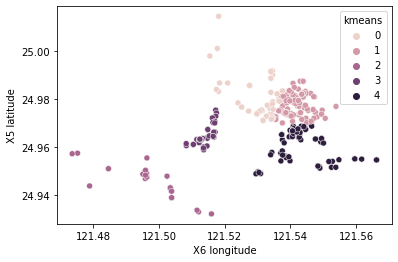

In [315]:
sb.scatterplot(df['X6 longitude'],df['X5 latitude'], hue=df['kmeans'])

/home/geovane/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='kmeans', ylabel='Y house price of unit area'>

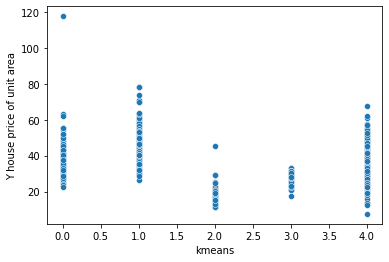

In [316]:
sb.scatterplot('kmeans', 'Y house price of unit area', data=df)

Com o plot é possível ver a diferença de preço em alguns grupos.

### Data processing

In [317]:
df = df.drop(columns=['No', 'X1 transaction date','X5 latitude','X6 longitude'])

## Training models

### Training with grouped

In [319]:
models = {
    'MLPRegressor': MLPRegressor(max_iter=1000),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVR': SVR(),
    'LinearRegression': LinearRegression()
}

In [320]:

mae = {
    'MLPRegressor': [],
    'RandomForestRegressor': [],
    'SVR': [],
    'LinearRegression':  []
}
mse = {
    'MLPRegressor': [],
    'RandomForestRegressor': [],
    'SVR': [],
    'LinearRegression':  []
}
def training_regressors():
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Y house price of unit area']), df['Y house price of unit area'])
    for i in range(100):
        for name in models:
            clf = models[name]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            mae[name].append(mean_absolute_error(y_test,y_pred))
            mse[name].append(np.sqrt(mean_squared_error(y_test, y_pred)))

df_results = {
    'Score':[],
    'Metric':[],
    'Regressor':[],
    'Grouped': []
}
training_regressors()
for name in models:
    df_results['Score'].append(np.mean(mae[name]))
    df_results['Metric'].append('MAE')
    df_results['Regressor'].append(name)
    df_results['Score'].append(np.mean(mse[name]))
    df_results['Metric'].append('RMSE')
    df_results['Regressor'].append(name)
    df_results['Grouped'].append('Yes')
    df_results['Grouped'].append('Yes')



### Training without grouped

In [321]:
df = df.drop(columns=['kmeans'])

In [322]:
mae = {
    'MLPRegressor': [],
    'RandomForestRegressor': [],
    'SVR': [],
    'LinearRegression':  []
}
mse = {
    'MLPRegressor': [],
    'RandomForestRegressor': [],
    'SVR': [],
    'LinearRegression':  []
}

In [323]:
training_regressors()
for name in models:
    df_results['Score'].append(np.mean(mae[name]))
    df_results['Metric'].append('MAE')
    df_results['Regressor'].append(name)
    df_results['Score'].append(np.mean(mse[name]))
    df_results['Metric'].append('RMSE')
    df_results['Regressor'].append(name)
    df_results['Grouped'].append('No')
    df_results['Grouped'].append('No')

### Ploting results

In [324]:
df_results = pd.DataFrame(df_results)

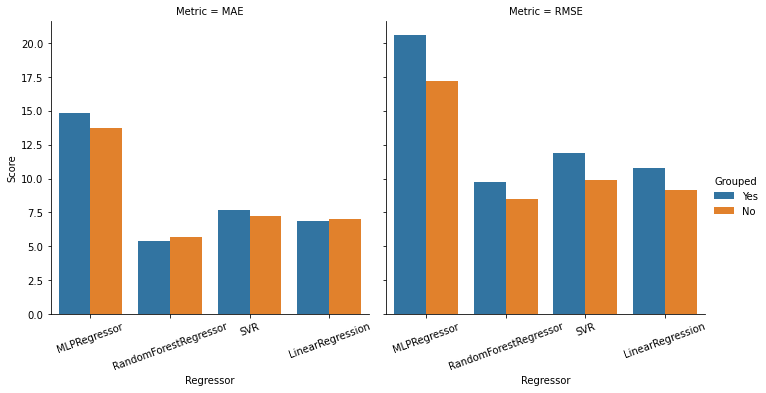

In [325]:
plot = sb.catplot(x='Regressor',y='Score', hue='Grouped',data=df_results, kind="bar", col='Metric')
for ax in plot.axes.flat:
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

Os Scores variam bastante em relação aos grupos, variam de acordo com o regressor e a métrica utilizados. Dessa forma optei por não utilizar o agrupamento.

## Incrising regressors